In [21]:
import torchvision as tv
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np

mnist_ds_path = '/home/miaohua/Documents/myfavor/mnist/datasets'
# you can change the batch_size, epochs, batch_limited to reach different accuracy
batch_size = 64
epoches = 15
batch_limited = 1000
alpha = 0.1
classes_num = 10
w, h = 28, 28


train_ds = tv.datasets.MNIST(root=mnist_ds_path, train=True, transform=transforms.ToTensor())
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)  #60000

test_ds = tv.datasets.MNIST(root=mnist_ds_path, train=False, transform=transforms.ToTensor())
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)    #10000

print('we have %d train samples, and %d test samples' % (len(train_dataloader), len(test_dataloader)))

we have 938 train samples, and 157 test samples


In [22]:
# do conv layers
kernel_shape = (3,3)
conv_channel = 16
stride = 1
hidden_size = int(((h-kernel_shape[0])/stride+1)*((w-kernel_shape[1])/stride+1)*conv_channel)

layer0_w = np.random.normal(0, 0.01, (kernel_shape[0]*kernel_shape[1], conv_channel))
layer1_w = np.random.normal(0, 0.01, (hidden_size, classes_num))

print('hidden_size', hidden_size)

hidden_size 10816


In [23]:
def relu(x):
    return np.where(x>0, x, 0)

def relu2driv(x):
    return np.where(x>0, 1, 0)

def dropout(x, dropout_prob):
    assert dropout_prob>0 and dropout_prob<=1   # when dropout_prob == 1, all are dropped out; dropout_prob == 0, nothing is dropped out
    
    ratio = 1.0/dropout_prob
    
    mask = np.random.uniform(0, 1.0, size=x.shape)
    mask = (mask > dropout_prob).astype(np.int32)
    
    return x*mask*ratio, mask

In [24]:
def mse(gt, pred):
    num = gt.shape[0]
    y = np.zeros((num, classes_num))
    y[np.arange(num), gt] = 1
    return np.sum((y-pred)**2)

def soft_max(pred):
    pred_max = pred.max(axis=1, keepdims=True)
    mid = np.exp(pred-pred_max).sum(axis=1, keepdims=True)
    return np.exp(pred-pred_max)/mid

def cross_entropy(gt, pred):
    mid = np.exp(pred).sum(axis=1, keepdims=True)
    num = pred.shape[0]
    return np.mean(np.log(mid)-pred[np.arange(num), gt])

In [25]:
def acc(gt, pred):
    pred = pred.argmax(axis=1)
    return np.mean(gt == pred)

In [26]:
def get_cnn_patches(x, kernel_shape):
    kernel_height, kernel_width = kernel_shape
    n, c, h, w = x.shape
    cnn_patches = []
    for n_ind in range(n):
        for h_ind in range(h-kernel_height+1):
            for w_ind in range(w-kernel_width+1):
                sub_section = x[n_ind,0,h_ind:h_ind+kernel_height,w_ind:w_ind+kernel_width]
                cnn_patches.append(sub_section)
    cnn_patches = np.stack(cnn_patches)
    
    return cnn_patches

In [27]:
def forward(x, sample_num, is_training, dropout_prob=0.5):
    x = x.reshape(x.shape[0], -1)
    mid_pred = x.dot(layer0_w)
    mid_pred = mid_pred.reshape(sample_num, -1)
    mid_pred = relu(mid_pred)
    
    if is_training and dropout_prob>0:
        mask_pred, mask = dropout(mid_pred, dropout_prob)
    else:
        mask_pred = mid_pred
        mask = None

    pred = mask_pred.dot(layer1_w)
    
    return pred, mid_pred, mask

def backward(gt, pred, mid_pred, mask, x):
    x = x.reshape(x.shape[0], -1)
    num = gt.shape[0]
    y = np.zeros((num, classes_num))
    y[np.arange(num), gt] = 1
    
    pred_soft_max = soft_max(pred)
    delta = (pred_soft_max-y)/num
    layer1_w_step = mid_pred.T.dot(delta)
    
    w_delta = delta.dot(layer1_w.T)*relu2driv(mid_pred)
    if mask is not None:
        w_delta = w_delta*mask
        
    w_delta = w_delta.reshape(-1, conv_channel)
    layer0_w_step = x.T.dot(w_delta)
    
    return layer0_w_step, layer1_w_step

def step(alpha, layer0_w_step, layer1_w_step):
    global layer0_w, layer1_w
    layer0_w = layer0_w - alpha * layer0_w_step
    layer1_w = layer1_w - alpha * layer1_w_step
    
def test():
    loss = 0
    accuracy = 0
    for x,y in test_dataloader:
        x = x.cpu().numpy()
        y = y.cpu().numpy()
        
        cnn_patches = get_cnn_patches(x, kernel_shape)
        pred, _, _ = forward(cnn_patches, y.shape[0], False)
        loss += cross_entropy(y, pred)
        accuracy += acc(y, pred)
    
    return loss/len(test_dataloader), accuracy/len(test_dataloader)

In [28]:
import time

dropout_prob = 0.0
for epoch in range(epoches):
    loss = 0
    accuracy = 0
    start = time.time()
    for idx, (x,y) in enumerate(train_dataloader):
        x = x.cpu().numpy()
        y = y.cpu().numpy()
        
        cnn_patches = get_cnn_patches(x, kernel_shape)
        pred, mid_pred, mask = forward(cnn_patches, y.shape[0], True, dropout_prob)
        loss += cross_entropy(y, pred)
        accuracy += acc(y, pred)
        
        layer0_w_step, layer1_w_step = backward(y, pred, mid_pred, mask, cnn_patches)
        step(alpha, layer0_w_step, layer1_w_step)
    
    # do test
    test_loss, test_acc = test()
    end = time.time()
    print('in epoch %d, train loss: %.4f, train acc: %.4f, test loss: %.4f, test acc: %.4f, cost %d seconds' % \
          (epoch, loss/(idx+1), accuracy/(idx+1), test_loss, test_acc, end-start))

in epoch 0, train loss: 0.4127, train acc: 0.8775, test loss: 0.2926, test acc: 0.9156, cost 79 seconds
in epoch 1, train loss: 0.2123, train acc: 0.9408, test loss: 0.1419, test acc: 0.9604, cost 79 seconds
in epoch 2, train loss: 0.1237, train acc: 0.9662, test loss: 0.0952, test acc: 0.9719, cost 78 seconds
in epoch 3, train loss: 0.0894, train acc: 0.9753, test loss: 0.0853, test acc: 0.9760, cost 77 seconds
in epoch 4, train loss: 0.0724, train acc: 0.9793, test loss: 0.0717, test acc: 0.9772, cost 79 seconds
in epoch 5, train loss: 0.0620, train acc: 0.9822, test loss: 0.0669, test acc: 0.9785, cost 77 seconds
in epoch 6, train loss: 0.0543, train acc: 0.9842, test loss: 0.0658, test acc: 0.9775, cost 77 seconds
in epoch 7, train loss: 0.0487, train acc: 0.9853, test loss: 0.0628, test acc: 0.9800, cost 77 seconds
in epoch 8, train loss: 0.0442, train acc: 0.9866, test loss: 0.0594, test acc: 0.9814, cost 76 seconds
in epoch 9, train loss: 0.0403, train acc: 0.9877, test loss: 0.

In [30]:
import torch as t
from torch import nn
from torch.nn import functional as F

# a pytorch equal example
class OneCnnClassifier(nn.Module):
    def __init__(self, classes_num, input_size, channels=16):
        super(OneCnnClassifier, self).__init__()
        
        self.conv1 = nn.Conv2d(1, channels, kernel_size=(3,3), stride=1)
        self.classifier = nn.Linear(channels*(input_size[0]-3+1)*(input_size[1]-3+1), classes_num)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(x.shape[0], -1)
        pred = self.classifier(x)
        
        return pred

In [31]:
def calc_acc(pred, y):
    p = pred.argmax(dim=1)
    return (p == y).float().mean()

def test(classifier, criterion):
    classifier.eval()
    
    loss = 0.0
    acc = 0.0
    iter_num = 0
    for (x, y) in test_dataloader:
        pred = classifier(x)
        
        cur_loss = criterion(pred, y)
        cur_acc = calc_acc(pred, y)

        loss += cur_loss.item()
        acc += cur_acc.item()
        
        iter_num += 1
    
    classifier.train()
    return loss/iter_num, acc/iter_num

In [33]:
import time

classifier = OneCnnClassifier(classes_num, (h,w))
criterion = nn.CrossEntropyLoss()
sgd = t.optim.SGD(classifier.parameters(), lr=alpha) #, momentum=0.9)

for epoch in range(epoches):
    loss = 0.0
    acc = 0.0
    iter_num = 0
    start = time.time()
    for idx, (x,y) in enumerate(train_dataloader):
        pred = classifier(x)
        
        sgd.zero_grad()
        cur_loss = criterion(pred, y)
        cur_acc = calc_acc(pred, y)
        cur_loss.backward()
        sgd.step()
        
        loss += cur_loss.item()
        acc += cur_acc.item()
        
        iter_num += 1 
    
    test_loss, test_acc = test(classifier, criterion)
    end = time.time()
    print('in epoch %d, train loss: %.4f, train acc: %.4f, test loss: %.4f, test acc: %.4f, cost %d seconds' % \
          (epoch, loss/iter_num, acc/iter_num, test_loss, test_acc, end-start))

in epoch 0, train loss: 0.2952, train acc: 0.9132, test loss: 0.1433, test acc: 0.9595, cost 11 seconds
in epoch 1, train loss: 0.1174, train acc: 0.9669, test loss: 0.0896, test acc: 0.9734, cost 9 seconds
in epoch 2, train loss: 0.0829, train acc: 0.9761, test loss: 0.0744, test acc: 0.9767, cost 9 seconds
in epoch 3, train loss: 0.0668, train acc: 0.9812, test loss: 0.0702, test acc: 0.9778, cost 9 seconds
in epoch 4, train loss: 0.0575, train acc: 0.9832, test loss: 0.0672, test acc: 0.9779, cost 9 seconds
in epoch 5, train loss: 0.0500, train acc: 0.9856, test loss: 0.0691, test acc: 0.9769, cost 11 seconds
in epoch 6, train loss: 0.0455, train acc: 0.9864, test loss: 0.0651, test acc: 0.9778, cost 11 seconds
in epoch 7, train loss: 0.0403, train acc: 0.9882, test loss: 0.0673, test acc: 0.9790, cost 10 seconds
in epoch 8, train loss: 0.0370, train acc: 0.9890, test loss: 0.0595, test acc: 0.9803, cost 11 seconds
in epoch 9, train loss: 0.0340, train acc: 0.9896, test loss: 0.0663

In [29]:
#可以看到我们自己的实现和pytorch实现在精度上相差无几，但是速度上差太多, cnn的计算并无差别，主要为函数get_cnn_patches太慢所致
#下面的思路把一次cnn layer变成一次大的矩阵相乘
alpha = 0.3
kernel_shape = (3,3)
conv_channel = 16
stride = 1
hidden_size = int(((h-kernel_shape[0])/stride+1)*((w-kernel_shape[1])/stride+1)*conv_channel)

kernel = np.random.normal(0, 0.01, (conv_channel, kernel_shape[0], kernel_shape[1]))
layer0_w = np.zeros((conv_channel, int(((h-kernel_shape[0])/stride+1)*((w-kernel_shape[1])/stride+1)),h*w))
layer1_w = np.random.normal(0, 0.01, (hidden_size, classes_num))

for k_ind in range(conv_channel):
    s = 0
    for i in range(layer0_w.shape[1]):
        for j in range(kernel.shape[1]):
            if s+j*w+kernel.shape[2]>=w:
                break
            layer0_w[k_ind,i,s+j*w:s+j*w+kernel.shape[2]] = kernel[k_ind,j,:] 
        s += stride 
layer0_w = layer0_w.transpose(0, 2, 1).reshape(h*w, -1)
layer0_mask = np.where(layer0_w!=0,1,0)

In [30]:
layer0_w.shape

(784, 10816)

In [31]:
def forward(x, sample_num, is_training, dropout_prob=0.5):
    x = x.reshape(x.shape[0], -1)
    mid_pred = relu(x.dot(layer0_w))
        
    if is_training and dropout_prob>0:
        mask_pred, mask = dropout(mid_pred, dropout_prob)
    else:
        mask_pred = mid_pred
        mask = None

    pred = mask_pred.dot(layer1_w)
    
    return pred, mid_pred, mask

def backward(gt, pred, mid_pred, mask, x):
    x = x.reshape(x.shape[0], -1)
    num = gt.shape[0]
    y = np.zeros((num, classes_num))
    y[np.arange(num), gt] = 1
    
    pred_soft_max = soft_max(pred)
    delta = (pred_soft_max-y)/num
    layer1_w_step = mid_pred.T.dot(delta)
    
    w_delta = delta.dot(layer1_w.T)*relu2driv(mid_pred)
    if mask is not None:
        w_delta = w_delta*mask
        
    layer0_w_step = x.T.dot(w_delta)*layer0_mask
    
    return layer0_w_step, layer1_w_step

def step(alpha, layer0_w_step, layer1_w_step):
    global layer0_w, layer1_w
    layer0_w = layer0_w - alpha * layer0_w_step
    layer1_w = layer1_w - alpha * layer1_w_step
    
def test():
    loss = 0
    accuracy = 0
    for x,y in test_dataloader:
        x = x.cpu().numpy()
        y = y.cpu().numpy()
        
        pred, _, _ = forward(x, y.shape[0], False)
        loss += cross_entropy(y, pred)
        accuracy += acc(y, pred)
    
    return loss/len(test_dataloader), accuracy/len(test_dataloader)

In [32]:
import time

for epoch in range(epoches):
    loss = 0
    accuracy = 0
    start = time.time()
    for idx, (x,y) in enumerate(train_dataloader):
        x = x.cpu().numpy()
        y = y.cpu().numpy()
        
        pred, mid_pred, mask = forward(x, y.shape[0], False)
        loss += cross_entropy(y, pred)
        accuracy += acc(y, pred)
        
        layer0_w_step, layer1_w_step = backward(y, pred, mid_pred, mask, x)
        step(alpha, layer0_w_step, layer1_w_step)
    
    # do test
    test_loss, test_acc = test()
    end = time.time()
    print('in epoch %d, train loss: %.4f, train acc: %.4f, test loss: %.4f, test acc: %.4f, cost %d seconds' % \
          (epoch, loss/(idx+1), accuracy/(idx+1), test_loss, test_acc, end-start))

in epoch 0, train loss: 1.6161, train acc: 0.4452, test loss: 1.3021, test acc: 0.5509, cost 71 seconds
in epoch 1, train loss: 1.3012, train acc: 0.5512, test loss: 1.2520, test acc: 0.5648, cost 71 seconds
in epoch 2, train loss: 1.2578, train acc: 0.5659, test loss: 1.2202, test acc: 0.5755, cost 71 seconds
in epoch 3, train loss: 1.2350, train acc: 0.5743, test loss: 1.2025, test acc: 0.5846, cost 73 seconds
in epoch 4, train loss: 1.2168, train acc: 0.5802, test loss: 1.1875, test acc: 0.5893, cost 77 seconds
in epoch 5, train loss: 1.2053, train acc: 0.5833, test loss: 1.1883, test acc: 0.5911, cost 80 seconds
in epoch 6, train loss: 1.1953, train acc: 0.5861, test loss: 1.1830, test acc: 0.5931, cost 76 seconds
in epoch 7, train loss: 1.1880, train acc: 0.5894, test loss: 1.1635, test acc: 0.6037, cost 78 seconds
in epoch 8, train loss: 1.1802, train acc: 0.5903, test loss: 1.1685, test acc: 0.5968, cost 78 seconds


KeyboardInterrupt: 

In [58]:
pred.shape

(64, 10)

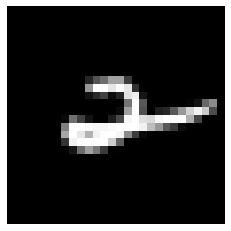

In [51]:
import numpy as np
from matplotlib import pyplot as plt

im = x[0,0,:,:]
fig = plt.figure()
plotwindow = fig.add_subplot(111)
plt.axis('off')
plt.imshow(im, cmap='gray')
plt.show()